# Purchase model using e-commerce data

## Import Packages

In [1]:
# data processing
import numpy as np
import pandas as pd
from datetime import date
import datetime as dt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
# plotting
import matplotlib.pyplot as plt
import seaborn as sns

from functools import reduce

### Setup

In [2]:
# full path of the orders dataset
orders_file = '../data/olist_orders_dataset.csv'

# full path of the customer dataset
cust_file = '../data/olist_customers_dataset.csv'

### Read files

In [3]:
orders = pd.read_csv(r"../data/olist_orders_dataset.csv", encoding='ISO-8859-2')

customers = pd.read_csv(r"../data/olist_customers_dataset.csv", encoding='ISO-8859-2')


In [4]:
orders.shape

(99441, 8)

In [5]:
#orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])

orders[['order_purchase_timestamp', 'order_approved_at','order_delivered_carrier_date',
    'order_delivered_customer_date','order_estimated_delivery_date']]=orders[[
    'order_purchase_timestamp', 'order_approved_at','order_delivered_carrier_date',
    'order_delivered_customer_date','order_estimated_delivery_date']].apply(pd.to_datetime)

## Exploratory

In [6]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [7]:
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


### Merge Orders and Customers

In [8]:
orders_cust = pd.merge(orders, customers, on='customer_id', how ='inner')
orders_cust.shape

orders_cust

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP
...,...,...,...,...,...,...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28,6359f309b166b0196dbf7ad2ac62bb5a,12209,sao jose dos campos,SP
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02,da62f9e57a76d978d02ab5362c509660,11722,praia grande,SP
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27,737520a9aad80b3fbbdad19b66b37b30,45920,nova vicosa,BA
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,5097a5312c8b157bb7be58ae360ef43c,28685,japuiba,RJ


### Binary Classification Model : DATA PREPARATION

Let's build a model to predict whether a customer will make atleast one purchase during the prediction window 

We will use January 2018 through July 2018, as the prediction window. In other words, we will use all available data prior to January 2018 to predict which customers will make a purchase during the prediction window.

In [9]:
snapshot_date = date(2017, 12, 31)

For creating model attributes (features) we will have to restrict our data to the timeframe prior to the prediction window.

In [10]:
mask = orders_cust['order_purchase_timestamp'].dt.date <= snapshot_date

mask.head()

0     True
1    False
2    False
3     True
4    False
Name: order_purchase_timestamp, dtype: bool

In [11]:
# apply the filter

df_merged = orders_cust[mask]

len(orders), len(df_merged)

(99441, 45430)

In [12]:
df_merged.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN
5,a4591c265e18cb1dcee52889e2d8acc3,503740e9ca751ccdda7ba28e9ab8f608,delivered,2017-07-09 21:57:05,2017-07-09 22:10:13,2017-07-11 14:58:04,2017-07-26 10:57:55,2017-08-01,80bb27c7c16e8f973207a5086ab329e2,86320,congonhinhas,PR
6,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,NaT,NaT,2017-05-09,36edbb3fb164b1f16485364b6fb04c73,98900,santa rosa,RS
7,6514b8ad8028c9f2cc2374ded245783f,9bdf08b4b3b52b5526ff42d37d47f222,delivered,2017-05-16 13:10:30,2017-05-16 13:22:11,2017-05-22 10:07:46,2017-05-26 12:55:51,2017-06-07,932afa1e708222e5821dac9cd5db4cae,26525,nilopolis,RJ


In [13]:
# check the max date

df_merged.order_purchase_timestamp.max()

Timestamp('2017-12-31 23:29:31')

### Attribute #1: Order recency

To calculate recency (days since the most recent order), we will have to extract the most recent date for each customer.

In [14]:
def order_recency(df_merged, snapshot_date):
    #Attribute #1: Order recency
    # grab the max purchase date for each customer
    max_cust_recency = df_merged.groupby('customer_unique_id')['order_purchase_timestamp'].max().reset_index()
    
    # count the number of days between the most recent order date and the snapshot date
    delta = snapshot_date - max_cust_recency['order_purchase_timestamp'].dt.date
    
    # grab the number of days (as an integer) from the calculated deltas 
    max_cust_recency['order_recency'] = delta.dt.days / 30
    max_cust_recency['order_recency'] = max_cust_recency['order_recency'].astype(int)
    
    # drop the date 
    max_cust_recency = max_cust_recency.drop('order_purchase_timestamp', axis=1)
    
    return max_cust_recency


In [15]:
max_cust_recency = order_recency(df_merged, snapshot_date)
max_cust_recency

,customer_unique_id,order_recency
0,0000f46a3911fa3c0805444483337064,9
1,0000f6ccb0745a6a4b88665a16c9f078,2
2,0004aac84e0df4da2b147fca70cf8255,1
3,0005e1862207bf6ccc02e4228effd9a0,10
4,0006fdc98a402fceb4eb0ee528f6a8d4,5
...,...,...
44029,fffbf87b7a1a6fa8b03f081c5f51a201,0
44030,fffcf5a5ff07b0908bd4e2dbc735a684,6
44031,fffea47cd6d3cc0a88bd621562a9d061,0
44032,ffff371b4d645b6ecea244b27531430a,10


In [16]:
# how many records (unique customers) do we have for this timeframe?
max_cust_recency.shape

(44034, 2)

This is the number of customers who are included in the modeling dasetset for this specific time-frame.

Let's check the distribution of this attribute.

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


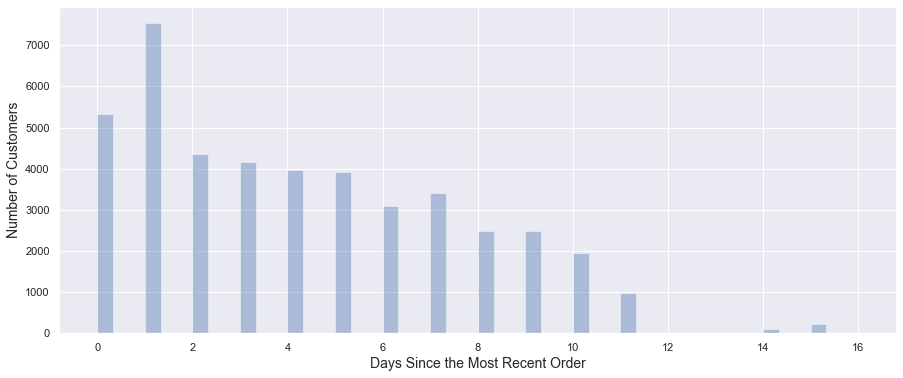

In [17]:
sns.set(style='darkgrid')

# adjust the plot size
plt.figure().set_size_inches(15, 6)

# histogram
sns.distplot(max_cust_recency['order_recency'], kde=False)

# assign axis labels
plt.ylabel('Number of Customers', fontsize=14)
plt.xlabel('Days Since the Most Recent Order', fontsize=14);

Let's take a look at the cumulative distribution of customers by recency.

In [18]:
recency_distr = max_cust_recency.groupby('order_recency').size().reset_index()

recency_distr = recency_distr.rename(columns={0: 'cust_count'})


In [19]:
# calculate cumulative percentages 

cum_pctg = recency_distr['cust_count'].cumsum() / sum(recency_distr['cust_count'])


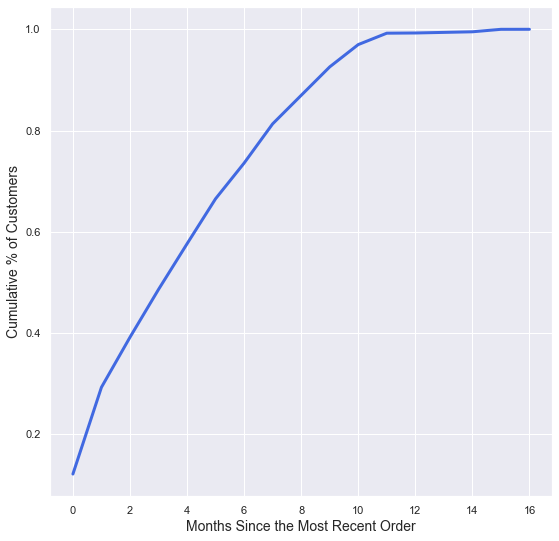

In [20]:
sns.set(style='darkgrid')

# adjust the plot size
plt.figure().set_size_inches(9, 9)

# histogram
sns.lineplot(x=recency_distr['order_recency'], y=cum_pctg, color='royalblue', lw=3)

# assign axis labels
plt.ylabel('Cumulative % of Customers', fontsize=14)
plt.xlabel('Months Since the Most Recent Order', fontsize=14);

### Attribute #2: Number of orders per customer

In [21]:
def No_of_orders(df_merged, snapshot_date):
    # count total records (i.e., orders) per customer
    cust_orders = df_merged.groupby('customer_unique_id').size().reset_index().rename(columns={0: 'total_orders'})

    return cust_orders

In [22]:
cust_orders = No_of_orders(df_merged, snapshot_date)

In [23]:
cust_orders.total_orders.value_counts()

1     42770
2      1164
3        80
4        14
5         4
10        1
6         1
Name: total_orders, dtype: int64

### Attribute set #3: Weekday

In [24]:
def weekday(df_merged):
    # Attribute set #3: Weekday

    df_merged['order_dow'] = df_merged['order_purchase_timestamp'].dt.day_name()
    
    # get dummies
    df_merged = pd.get_dummies(df_merged, columns=['order_dow'])
    
    # grab all binary columns that we just created
    dummies = [x for x in df_merged.columns if 'order_dow_' in x]
    
    # aggreagte data to the customer-level, so that we have one record per customer
    cust_dow = df_merged.groupby('customer_unique_id')[dummies].sum().reset_index()
    
    #cust_dow[cust_dow['order_dow_Monday'] > 1]
    
    return cust_dow

In [25]:
cust_dow = weekday(df_merged)

cust_dow

<ipython-input-24-acd99488dc0b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged['order_dow'] = df_merged['order_purchase_timestamp'].dt.day_name()


,customer_unique_id,order_dow_Friday,order_dow_Monday,order_dow_Saturday,order_dow_Sunday,order_dow_Thursday,order_dow_Tuesday,order_dow_Wednesday
0,0000f46a3911fa3c0805444483337064,1,0,0,0,0,0,0
1,0000f6ccb0745a6a4b88665a16c9f078,0,0,0,0,1,0,0
2,0004aac84e0df4da2b147fca70cf8255,0,0,0,0,0,1,0
3,0005e1862207bf6ccc02e4228effd9a0,0,0,1,0,0,0,0
4,0006fdc98a402fceb4eb0ee528f6a8d4,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...
44029,fffbf87b7a1a6fa8b03f081c5f51a201,0,0,0,0,0,0,1
44030,fffcf5a5ff07b0908bd4e2dbc735a684,0,0,0,0,1,0,0
44031,fffea47cd6d3cc0a88bd621562a9d061,0,0,0,1,0,0,0
44032,ffff371b4d645b6ecea244b27531430a,0,0,0,0,0,1,0


### Attribute set #4: Month (How many orders placed each month by each customer)

In [26]:
def order_month(df_merged):
    df_merged['order_month'] = df_merged['order_purchase_timestamp'].dt.strftime('%b')
    
    # grab all binary columns that we just created
    df_merged = pd.get_dummies(df_merged, columns=['order_month'])
    
    dummies2 = [x for x in df_merged.columns if 'order_month_' in x]
    
    # aggreagte data to the customer-level, so that we have one record per customer
    cust_month = df_merged.groupby('customer_unique_id')[dummies2].sum().reset_index()

    return cust_month

In [27]:
cust_month = order_month(df_merged)

cust_month

<ipython-input-26-ce936d2aeb4b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged['order_month'] = df_merged['order_purchase_timestamp'].dt.strftime('%b')


,customer_unique_id,order_month_Apr,order_month_Aug,order_month_Dec,order_month_Feb,order_month_Jan,order_month_Jul,order_month_Jun,order_month_Mar,order_month_May,order_month_Nov,order_month_Oct,order_month_Sep
0,0000f46a3911fa3c0805444483337064,0,0,0,0,0,0,0,1,0,0,0,0
1,0000f6ccb0745a6a4b88665a16c9f078,0,0,0,0,0,0,0,0,0,0,1,0
2,0004aac84e0df4da2b147fca70cf8255,0,0,0,0,0,0,0,0,0,1,0,0
3,0005e1862207bf6ccc02e4228effd9a0,0,0,0,0,0,0,0,1,0,0,0,0
4,0006fdc98a402fceb4eb0ee528f6a8d4,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
44029,fffbf87b7a1a6fa8b03f081c5f51a201,0,0,1,0,0,0,0,0,0,0,0,0
44030,fffcf5a5ff07b0908bd4e2dbc735a684,0,0,0,0,0,0,1,0,0,0,0,0
44031,fffea47cd6d3cc0a88bd621562a9d061,0,0,1,0,0,0,0,0,0,0,0,0
44032,ffff371b4d645b6ecea244b27531430a,0,0,0,1,0,0,0,0,0,0,0,0


### Attribute set #5: Av. diff between order purchase and delivery   

In [72]:
def avg_diff_order_purch_delv (df_merged):
    df_merged['Difference'] = (df_merged['order_delivered_customer_date'] - df_merged['order_purchase_timestamp']).dt.days

    # aggreagte data to the customer-level, so that we have one record per customer
    av_cust_aggregate = df_merged.groupby('customer_unique_id')['Difference'].mean().reset_index().rename(columns={'Difference': 'avg_difference'})
    
    return av_cust_aggregate                                                                                                                                                                                                                      

In [73]:
av_cust_aggregate = avg_diff_order_purch_delv(df_merged)

test = av_cust_aggregate[av_cust_aggregate['customer_unique_id'] == '36edbb3fb164b1f16485364b6fb04c73']

test

av_cust_aggregate.avg_difference.value_counts

<ipython-input-72-740a91ea3c05>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged['Difference'] = (df_merged['order_delivered_customer_date'] - df_merged['order_purchase_timestamp']).dt.days


<bound method IndexOpsMixin.value_counts of 0        25.0
1        20.0
2        13.0
3         4.0
4        16.0
         ... 
44029    18.0
44030    27.0
44031    30.0
44032    14.0
44033     7.0
Name: avg_difference, Length: 44034, dtype: float64>

In [78]:
av_cust_aggregate.avg_difference = av_cust_aggregate.avg_difference.replace(np.nan, 300)

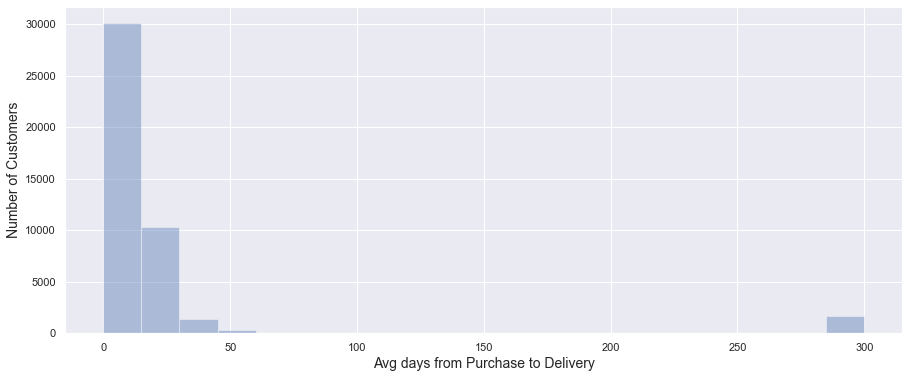

In [79]:
sns.set(style='darkgrid')

# adjust the plot size
plt.figure().set_size_inches(15, 6)

# histogram
sns.distplot(av_cust_aggregate['avg_difference'], kde=False, bins=20)

# assign axis labels
plt.ylabel('Number of Customers', fontsize=14)
plt.xlabel('Avg days from Purchase to Delivery', fontsize=14);

### Attribute set #6: Av. diff between order estimated and delivered date   

In [91]:
def avg_diff_order_est_delv(df_merged):
    df_merged['diff_dlv_est'] = (df_merged['order_estimated_delivery_date'] - df_merged['order_delivered_customer_date']).dt.days
    # aggreagte data to the customer-level, so that we have one record per customer
    av_cust_aggregate2 = df_merged.groupby('customer_unique_id')['diff_dlv_est'].mean().reset_index().rename(columns={'diff_dlv_est': 'avg_difference2'})
    
    return  av_cust_aggregate2

In [92]:
av_cust_aggregate2 = avg_diff_order_est_delv(df_merged)

print(av_cust_aggregate2.avg_difference2.count()) 
print(av_cust_aggregate2.avg_difference2.shape)

42398
(44034,)


<ipython-input-91-d45c05698326>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged['diff_dlv_est'] = (df_merged['order_estimated_delivery_date'] - df_merged['order_delivered_customer_date']).dt.days


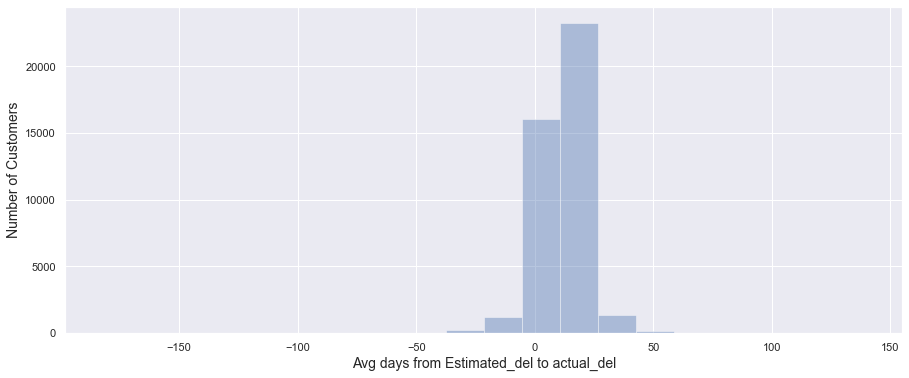

In [93]:
sns.set(style='darkgrid')

# adjust the plot size
plt.figure().set_size_inches(15, 6)

# histogram
sns.distplot(av_cust_aggregate2['avg_difference2'], kde=False, bins=20)

# assign axis labels
plt.ylabel('Number of Customers', fontsize=14)
plt.xlabel('Avg days from Estimated_del to actual_del', fontsize=14);

### Attribute set #7: Total number of orders of each customer by location

In [94]:
def cust_order_location(df_merged):
#Check orders placed by a customer from each location 
#calculate total orders for each state
    orders_cust.customer_state.value_counts()
#Check orders placed by a customer from each location    
    cust_orders_state = df_merged.groupby(['customer_unique_id', 
                                    'customer_state']).size().reset_index() \
                                        .rename(columns={0: 'state_total_orders'})
   
    cust_state_pivot = cust_orders_state.pivot(index = 'customer_unique_id', columns = 'customer_state', 
                               values = 'state_total_orders').rename_axis(None, axis=1).reset_index()
    
    cust_state_pivot = cust_state_pivot.fillna(0)
    
    return cust_state_pivot
    #cust_orders_state[cust_orders_state['state_total_orders'] > 1]

In [95]:
cust_state_pivot = cust_order_location(df_merged)

cust_state_pivot

,customer_unique_id,AC,AL,AM,AP,BA,CE,DF,ES,GO,...,PR,RJ,RN,RO,RR,RS,SC,SE,SP,TO
0,0000f46a3911fa3c0805444483337064,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0000f6ccb0745a6a4b88665a16c9f078,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0004aac84e0df4da2b147fca70cf8255,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0005e1862207bf6ccc02e4228effd9a0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0006fdc98a402fceb4eb0ee528f6a8d4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44029,fffbf87b7a1a6fa8b03f081c5f51a201,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44030,fffcf5a5ff07b0908bd4e2dbc735a684,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44031,fffea47cd6d3cc0a88bd621562a9d061,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44032,ffff371b4d645b6ecea244b27531430a,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
#cust_orders_state[cust_orders_state['customer_unique_id'].duplicated() ]
#cust_orders_state[cust_orders_state['customer_unique_id'] == '2410195f6521688005612363835a2671']

### Attribute set #8: weekday vs weekend

In [103]:
def weekday_vs_weekend(df_merged):
    df_merged['is_weekend'] = df_merged['order_dow'].apply(lambda x: 'weekend' if x == 'Sunday' or x == 'Saturday' else 'weekday')
    #create dummies
    df_merged = pd.get_dummies(df_merged, columns=['is_weekend'])
    #create two new columns
    dummies = [x for x in df_merged.columns if 'is_weekend' in x]
    print(dummies)
    Wkend_vs_wkday = df_merged.groupby(['customer_unique_id'])[dummies].sum().reset_index()
    
    return Wkend_vs_wkday

In [104]:
Wkend_vs_wkday = weekday_vs_weekend(df_merged)

Wkend_vs_wkday

['is_weekend_weekday', 'is_weekend_weekend']


<ipython-input-103-c88466fe408e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged['is_weekend'] = df_merged['order_dow'].apply(lambda x: 'weekend' if x == 'Sunday' or x == 'Saturday' else 'weekday')


,customer_unique_id,is_weekend_weekday,is_weekend_weekend
0,0000f46a3911fa3c0805444483337064,1,0
1,0000f6ccb0745a6a4b88665a16c9f078,1,0
2,0004aac84e0df4da2b147fca70cf8255,1,0
3,0005e1862207bf6ccc02e4228effd9a0,0,1
4,0006fdc98a402fceb4eb0ee528f6a8d4,1,0
...,...,...,...
44029,fffbf87b7a1a6fa8b03f081c5f51a201,1,0
44030,fffcf5a5ff07b0908bd4e2dbc735a684,1,0
44031,fffea47cd6d3cc0a88bd621562a9d061,0,1
44032,ffff371b4d645b6ecea244b27531430a,1,0


In [39]:
#different way to calculate weekend vs weekdays
# def is_weekday(orders_dow):
#     if orders_dow == 'Sunday' or orders_dow == 'Saturday':
#         return 'Y'
#     else:
#         return 'N'

# df_merged['is_weekend'] = df_merged['order_dow'].apply(is_weekday)

### Combine all attributes into a single dataframe

In [106]:
# let's check the number of records in each dataframe first

max_cust_recency.shape, cust_orders.shape, cust_dow.shape, cust_month.shape, av_cust_aggregate.shape, av_cust_aggregate2.shape, cust_state_pivot.shape, Wkend_vs_wkday.shape



((44034, 2),
 (44034, 2),
 (44034, 8),
 (44034, 13),
 (44034, 2),
 (44034, 2),
 (44034, 28),
 (44034, 3))

In [107]:
# combine (merge) attributes so that we have all the attributes in one dataset
all_data_frames = [max_cust_recency, cust_orders, cust_dow, cust_month, av_cust_aggregate, av_cust_aggregate2,
                   cust_state_pivot, Wkend_vs_wkday]
df_combined = reduce(lambda  left,right: pd.merge(left,right,on=['customer_unique_id'],
                                            how='outer'), all_data_frames)
#convert list into dataframe
df_combined = pd.DataFrame(df_combined)

df_combined

,customer_unique_id,order_recency,total_orders,order_dow_Friday,order_dow_Monday,order_dow_Saturday,order_dow_Sunday,order_dow_Thursday,order_dow_Tuesday,order_dow_Wednesday,...,RN,RO,RR,RS,SC,SE,SP,TO,is_weekend_weekday,is_weekend_weekend
0,0000f46a3911fa3c0805444483337064,9,1,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,0
1,0000f6ccb0745a6a4b88665a16c9f078,2,1,0,0,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
2,0004aac84e0df4da2b147fca70cf8255,1,1,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,0
3,0005e1862207bf6ccc02e4228effd9a0,10,1,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
4,0006fdc98a402fceb4eb0ee528f6a8d4,5,1,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44029,fffbf87b7a1a6fa8b03f081c5f51a201,0,1,0,0,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
44030,fffcf5a5ff07b0908bd4e2dbc735a684,6,1,0,0,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
44031,fffea47cd6d3cc0a88bd621562a9d061,0,1,0,0,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
44032,ffff371b4d645b6ecea244b27531430a,10,1,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0


#### Exclude customers who have not placed an order within the past one year

In [108]:
df_combined = df_combined[df_combined['order_recency'] <= 12]

In [109]:
df_combined.shape


(43713, 53)

### Assign labels (aka the target variable or the dependent variable)

For this exercise, we will assume that the objective of the model is to predict whether a customer will make at least one purchase in the future (i.e., within the target window of the model).

**Step 1:** Isolate all orders that were placed within the prediction window.

In [110]:
# select orders that were placed from Jan 2018 to July 2018
startdate = date(2018, 1, 1)

In [111]:
end_date = date(2018, 7, 31)

In [112]:
mask2 = orders_cust['order_purchase_timestamp'].dt.date >= startdate 
mask3 = orders_cust['order_purchase_timestamp'].dt.date <= end_date

In [113]:
#apply masks to get the test dataframe
test_df = orders_cust[mask2 & mask3]

test_df

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP
12,82566a660a982b15fb86e904c8d32918,d3e3b74c766bc6214e0c830b17ee2341,delivered,2018-06-07 10:06:19,2018-06-09 03:13:12,2018-06-11 13:29:00,2018-06-19 12:05:52,2018-07-18,e97109680b052ee858d93a539597bba7,35400,ouro preto,MG
13,5ff96c15d0b717ac6ad1f3d77225a350,19402a48fe860416adf93348aba37740,delivered,2018-07-25 17:44:10,2018-07-25 17:55:14,2018-07-26 13:16:00,2018-07-30 15:52:25,2018-08-08,e2dfa3127fedbbca9707b36304996dab,4812,sao paulo,SP
14,432aaf21d85167c2c86ec9448c4e42cc,3df704f53d3f1d4818840b34ec672a9f,delivered,2018-03-01 14:14:28,2018-03-01 15:10:47,2018-03-02 21:09:20,2018-03-12 23:36:26,2018-03-21,04cf8185c71090d28baa4407b2e6d600,5271,sao paulo,SP
...,...,...,...,...,...,...,...,...,...,...,...,...
99428,c22a47117b6a87c967b0c278488110c1,6e153567dc52ea59c0498ef5383e9c7a,delivered,2018-06-22 20:53:29,2018-06-22 21:17:45,2018-06-25 17:50:00,2018-07-03 19:48:54,2018-07-23,e930b415f39ab827ea66de80a9d36a22,13218,jundiai,SP
99430,c81f74e50f0496fa39716cc77cacd460,7b270ebc87c25c8404348c10ff80a80e,delivered,2018-03-04 22:48:38,2018-03-04 23:09:22,2018-03-05 16:15:04,2018-03-13 18:54:32,2018-03-26,324a22205906aa2612a33e63c00ca8bb,31130,belo horizonte,MG
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02,da62f9e57a76d978d02ab5362c509660,11722,praia grande,SP
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,5097a5312c8b157bb7be58ae360ef43c,28685,japuiba,RJ


In [114]:
# confirm the min and max dates
print (test_df['order_purchase_timestamp'].min(), test_df['order_purchase_timestamp'].max())

2018-01-01 02:48:41 2018-07-31 23:54:20


**Step 2:** Summarize data to get one record per customer.

In [115]:
# count the number of orders (we will convert this into a binary flag later)

test_dataframe = test_df.groupby('customer_unique_id').size().reset_index().rename(columns={0: 'purch'})

#Customers who have purchased within the prediction window
test_dataframe['purch'] = 1

In [116]:
test_dataframe.purch.value_counts()

1    46412
Name: purch, dtype: int64

In [117]:
print(f'Number of customers who made at least one purchase durnig the prediction window: {len(test_dataframe):,}')

Number of customers who made at least one purchase durnig the prediction window: 46,412


**Step 3:** Merge this dataframe with the `attr` dataframe to create the modeling dataset.

In [118]:
# merge `target_events` with the dataframe that contains customer attributes
#ones who purchase put value 1 and 0 if not

model_df = pd.merge(df_combined, test_dataframe, how='left', on='customer_unique_id')

model_df

,customer_unique_id,order_recency,total_orders,order_dow_Friday,order_dow_Monday,order_dow_Saturday,order_dow_Sunday,order_dow_Thursday,order_dow_Tuesday,order_dow_Wednesday,...,RO,RR,RS,SC,SE,SP,TO,is_weekend_weekday,is_weekend_weekend,purch
0,0000f46a3911fa3c0805444483337064,9,1,1,0,0,0,0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,0,NaN
1,0000f6ccb0745a6a4b88665a16c9f078,2,1,0,0,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,NaN
2,0004aac84e0df4da2b147fca70cf8255,1,1,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,0,NaN
3,0005e1862207bf6ccc02e4228effd9a0,10,1,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,NaN
4,0006fdc98a402fceb4eb0ee528f6a8d4,5,1,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43708,fffbf87b7a1a6fa8b03f081c5f51a201,0,1,0,0,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,NaN
43709,fffcf5a5ff07b0908bd4e2dbc735a684,6,1,0,0,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,NaN
43710,fffea47cd6d3cc0a88bd621562a9d061,0,1,0,0,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,NaN
43711,ffff371b4d645b6ecea244b27531430a,10,1,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,NaN


In [119]:
#replace NaN to 0 in purch column
model_df['purch'] = model_df['purch'].fillna(0)

In [120]:
model_df.purch.value_counts()

0.0    43091
1.0      622
Name: purch, dtype: int64

In [121]:
# % distribution of the target flag

model_df.purch.value_counts() / len(model_df)

0.0    0.985771
1.0    0.014229
Name: purch, dtype: float64

There are two issues here: (1) the target event is extremely rare, and (2) the number of target events is also extremely small.

In [122]:
# check the correlations

model_df.corr()['purch']

order_recency         -0.013936
total_orders           0.070029
order_dow_Friday      -0.000731
order_dow_Monday       0.012103
order_dow_Saturday    -0.003484
order_dow_Sunday       0.012515
order_dow_Thursday     0.003865
order_dow_Tuesday      0.007170
order_dow_Wednesday    0.006607
order_month_Apr       -0.011012
order_month_Aug        0.012872
order_month_Dec        0.011475
order_month_Feb       -0.007043
order_month_Jan        0.006259
order_month_Jul        0.004387
order_month_Jun        0.004202
order_month_Mar       -0.004089
order_month_May        0.000918
order_month_Nov        0.003840
order_month_Oct        0.006814
order_month_Sep        0.012755
avg_difference        -0.005475
avg_difference2        0.002910
AC                     0.006535
AL                    -0.002574
AM                     0.004042
AP                    -0.002994
BA                    -0.005658
CE                    -0.009942
DF                    -0.000137
ES                    -0.002219
GO      

Before moving on to model building, let create a two-axis plot to view the purchase rates by recency.

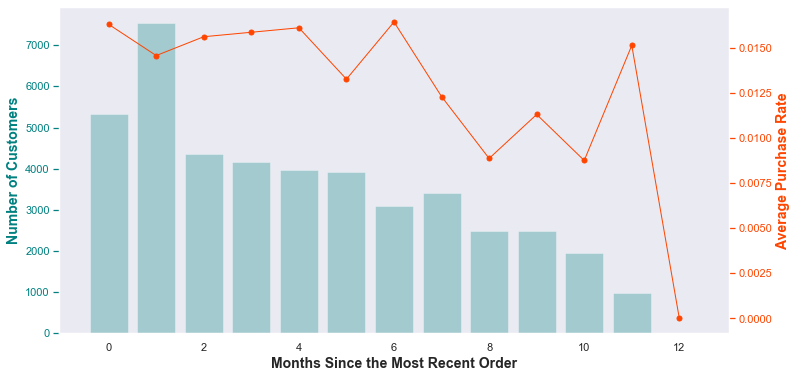

In [123]:
purch_rate_by_recency = model_df.groupby('order_recency')['purch'].mean().reset_index()
purch_rate_by_recency['orders'] = model_df.groupby('order_recency').size().reset_index()[0]

sns.set(style = 'dark')
f, ax = plt.subplots(figsize = (12, 6))

# create a secondary axis
ax2 = ax.twinx()

ax.bar(purch_rate_by_recency['order_recency'], purch_rate_by_recency['orders'], color='teal', alpha=0.3)

ax2.plot(purch_rate_by_recency['order_recency'], purch_rate_by_recency['purch'], 
         color='orangered', marker='o', markersize=5, lw=1)

ax.set_xlabel('Months Since the Most Recent Order', fontsize=14, weight='bold')
ax.set_ylabel('Number of Customers', fontsize=14, weight='bold', color='teal')
ax2.set_ylabel('Average Purchase Rate', fontsize = 14, color='orangered', weight='bold')

ax.tick_params(axis='y', colors='teal')
ax2.tick_params(axis='y', colors='orangered')

# Two-fold partition

#### Created two fold partition with oversampling and without oversampling using a two_fold_partition function

In [124]:
def two_fold_partition (X, y):

    # split the dataframe into train(70%) and test(30%)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1111)
    
    # target distribution in the trainig sample
    print('target distribution in the trainig sample')
    print(y_train.value_counts())
    print('')
    # target distribution in the test sample
    print('target distribution in the test sample')
    print(y_test.value_counts())

    return X_train, X_test, y_train, y_test

### Two fold partitioning with Oversampling

In [125]:
df_nonevents = model_df[model_df['purch'] == 0]
df_events = model_df[model_df['purch'] == 1].sample(len(df_nonevents), replace = True)

df_os_model = pd.concat([df_events, df_nonevents])
df_os_model.shape

(86182, 54)

In [132]:
df_nonevents.shape

(43091, 54)

In [61]:
df_events.shape

(43091, 54)

In [133]:
df_os_model.columns

Index(['customer_unique_id', 'order_recency', 'total_orders',
       'order_dow_Friday', 'order_dow_Monday', 'order_dow_Saturday',
       'order_dow_Sunday', 'order_dow_Thursday', 'order_dow_Tuesday',
       'order_dow_Wednesday', 'order_month_Apr', 'order_month_Aug',
       'order_month_Dec', 'order_month_Feb', 'order_month_Jan',
       'order_month_Jul', 'order_month_Jun', 'order_month_Mar',
       'order_month_May', 'order_month_Nov', 'order_month_Oct',
       'order_month_Sep', 'avg_difference', 'avg_difference2', 'AC', 'AL',
       'AM', 'AP', 'BA', 'CE', 'DF', 'ES', 'GO', 'MA', 'MG', 'MS', 'MT', 'PA',
       'PB', 'PE', 'PI', 'PR', 'RJ', 'RN', 'RO', 'RR', 'RS', 'SC', 'SE', 'SP',
       'TO', 'is_weekend_weekday', 'is_weekend_weekend', 'purch'],
      dtype='object')

In [134]:
#replace NaN to 0 in purch column
df_os_model = df_os_model.fillna(0)

In [136]:
# set-up X and y for oversampled data

preds = df_os_model.columns[1:-1]

X_O = df_os_model[preds]
y_o = df_os_model['purch']

X_O_train, X_O_test, y_o_train, y_o_test = two_fold_partition(X_O, y_o)

target distribution in the trainig sample
0.0    30165
1.0    30162
Name: purch, dtype: int64

target distribution in the test sample
1.0    12929
0.0    12926
Name: purch, dtype: int64


### Two fold partitioning without Oversampling

In [137]:
#replace NaN to 0 in purch column
model_df = model_df.fillna(0)

In [138]:
# set-up X and y for non oversampled data

preds = model_df.columns[1:-1]

X_NO = model_df[preds]
y_no = model_df['purch']

X_NO_train, X_NO_test, y_no_train, y_no_test = two_fold_partition(X_NO, y_no)

target distribution in the trainig sample
0.0    30169
1.0      430
Name: purch, dtype: int64

target distribution in the test sample
0.0    12922
1.0      192
Name: purch, dtype: int64


In [139]:
#To check nulls if any
X_O_train.isnull().values.any()

False

### Model accuracy

In [140]:
def model_accuracy_scores (y_test, y_preds, y_scores):

    # calcualte AUC
    AUC_score = roc_auc_score(y_test, y_scores)
    print('AUC score: ', AUC_score)
    
    # calcualte Accuracy_score
    Model_accuracy_score = accuracy_score(y_test, y_preds)
    print('Accuracy Score: ', Model_accuracy_score)
                   
    # check model's predictions against actual value of the target event
    crosstab = pd.crosstab(y_test, y_preds)
    print('')
    print('Confusion Matrix')
    print(crosstab)
    print('')
    #Precision
    average_precision = average_precision_score(y_test, y_scores)
    
    #Since it is an imbalanced dataset, we need to calculate f1_score, preciaion_score and recall_score
    print('F1 score: ', f1_score(y_test, y_preds, average="macro"))
    print('Precision score: ', precision_score(y_test, y_preds, average="macro"))
    print('Recall score: ', recall_score(y_test, y_preds, average="macro"))
    
    return AUC_score


# Model Building

### Model building with oversampling

#### Logistic Regression Model

In [141]:
#define the model object ('liblinear' is recommended for small datasets)
clf_O_lr = LogisticRegression(solver='liblinear', random_state=1111)
#train (fit) the model using the training sample
clf_O_lr.fit(X_O_train, y_o_train)

#make predictions on the test sample
y_o_preds = clf_O_lr.predict(X_O_test)

# calculate the probabilities on the test sample
y_o_scores_lr = clf_O_lr.predict_proba(X_O_test)[:, 1]

print('Mean of probability scores for LR: ', clf_O_lr.predict_proba(X_O_train)[:, 1].mean())

Mean of probability scores for LR:  0.49998574785310385


In [142]:
print('Logistic Regression Performance Metrics')
print('')
LR_O_AUC = model_accuracy_scores(y_o_test, y_o_preds, y_o_scores_lr)

Logistic Regression Performance Metrics

AUC score:  0.6041824110679008
Accuracy Score:  0.5631792690001934

Confusion Matrix
col_0   0.0   1.0
purch            
0.0    7125  5801
1.0    5493  7436

F1 score:  0.5631160572555874
Precision score:  0.5632141131946502
Recall score:  0.5631778808809134


In [143]:
# Classification report to check if scores are even or uneven for each class
print(classification_report(y_o_test, y_o_preds, target_names=['0', '1']))

              precision    recall  f1-score   support

           0       0.56      0.55      0.56     12926
           1       0.56      0.58      0.57     12929

    accuracy                           0.56     25855
   macro avg       0.56      0.56      0.56     25855
weighted avg       0.56      0.56      0.56     25855



#### Logistic Regression model scores are evenly distributed for each of the classes

#### Decision Tree Model

In [159]:
# Create Decision Tree classifer object
clf_O_dt = DecisionTreeClassifier(class_weight='balanced', random_state=1111)

# Train Decision Tree Classifer
clf_O_dt = clf_O_dt.fit(X_O_train, y_o_train)

#Predict the response for test dataset
y_o_pred_dt = clf_O_dt.predict(X_O_test)

# calculate the probabilities on the test sample
y_o_scores_dt = clf_O_dt.predict_proba(X_O_test)[:, 1]

print('Mean of probability scores for DT: ', clf_O_dt.predict_proba(X_O_train)[:, 1].mean())

Mean of probability scores for DT:  0.49997586778263525


In [160]:
print('Decision Tree Performance Metrics')
print('')
DT_AUC = model_accuracy_scores(y_o_test, y_o_pred_dt, y_o_scores_dt)

Decision Tree Performance Metrics

AUC score:  0.9850875615591155
Accuracy Score:  0.9812802165925353

Confusion Matrix
col_0    0.0    1.0
purch              
0.0    12442    484
1.0        0  12929

F1 score:  0.9812735726821258
Precision score:  0.9819578021322597
Recall score:  0.9812780442518954


In [162]:
# Classification report to check if scores are even or uneven for each class
print(classification_report(y_o_test, y_o_pred_dt, target_names=['0', '1']))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     12926
           1       0.96      1.00      0.98     12929

    accuracy                           0.98     25855
   macro avg       0.98      0.98      0.98     25855
weighted avg       0.98      0.98      0.98     25855



#### Decision Tree model scores are evenly distributed for each of the classes

### Pearson Correlation

In [73]:
y__o_scores_lr
y_o_scores_dt

df_y_o_scores = pd.DataFrame(y__o_scores_lr, y_o_scores_dt).reset_index().rename(columns={0: 'Dec_Tree', 'index': 'Log_Reg'})

df_y_o_scores.head()

pearsoncorr = df_y_o_scores.corr(method='pearson')

pearsoncorr

,Log_Reg,Dec_Tree
Log_Reg,1.000000,0.210318
Dec_Tree,0.210318,1.000000


### ROC AUC Curve

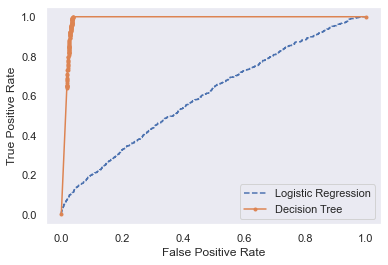

In [74]:
lr_fpr, lr_tpr, _ = roc_curve(y_o_test, y__o_scores_lr)
dt_fpr, dt_tpr, _ = roc_curve(y_o_test, y_o_scores_dt)
# plot the roc curve for the model
plt.plot(lr_fpr, lr_tpr, linestyle='--', label='Logistic Regression')
plt.plot(dt_fpr, dt_tpr, marker='.', label='Decision Tree')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

### Based on the model validation scores, It is recommended to use Decision Tree model

## _k_-fold Cross-validation

#### Logistic Regression _k_-fold Cross-validation

In [79]:
# let's use three folds
k_folds = 3
clf_O_lr = LogisticRegression(solver='liblinear', random_state=1111)
auc_scores = []

for k in range(k_folds):
    
    X_train_k, X_test_k, y_train_k, y_test_k = \
        train_test_split(X_O, y_o, test_size=1/k_folds)

    clf.fit(X_train_k, y_train_k)
    
    y_scores_k = clf.predict_proba(X_test_k)[:, 1]

    # calcualte AUC
    auc = roc_auc_score(y_test_k, y_scores_k)
    
    auc_scores.append(auc)
    
print('AUC Scores: ', auc_scores)
print('Mean AUC Score: ', sum(auc_scores)/len(auc_scores))

AUC Scores:  [0.5998707375219239, 0.604362575305211, 0.6030231445418144]
Mean AUC Score:  0.602418819122983


#### Decision Tree _k_-fold Cross-validation

In [80]:
# let's use three folds
k_folds = 3
clf_O_dt = DecisionTreeClassifier(class_weight='balanced', random_state=1111)
auc_scores = []

for k in range(k_folds):
    
    X_train_k, X_test_k, y_train_k, y_test_k = \
        train_test_split(X_O, y_o, test_size=1/k_folds)

    clf.fit(X_train_k, y_train_k)
    
    y_scores_k = clf.predict_proba(X_test_k)[:, 1]

    # calcualte AUC
    auc = roc_auc_score(y_test_k, y_scores_k)
    
    auc_scores.append(auc)
    
print('AUC Scores: ', auc_scores)
print('Mean AUC Score: ', sum(auc_scores)/len(auc_scores))

AUC Scores:  [0.6032123880379845, 0.6041404681281233, 0.5993170804857553]
Mean AUC Score:  0.6022233122172876


# Model building without oversampling

#### Logistic Regression Model

In [139]:
clf = LogisticRegression(solver='liblinear', class_weight='balanced', random_state=1111)
#train (fit) the model using the training sample
clf.fit(X_NO_train, y_no_train)

#make predictions on the test sample
y_preds = clf.predict(X_NO_test)

# calculate the probabilities on the test sample
y_scores_lr = clf.predict_proba(X_NO_test)[:, 1]

print('Mean of probability scores for LR: ', clf.predict_proba(X_NO_train)[:, 1].mean())

Mean of probability scores for LR:  0.47985434988895925


In [140]:
print('Logistic Regression Performance Metrics')
print('')
LR_AUC = model_accuracy_scores(y_no_test, y_preds, y_scores_lr)

Logistic Regression Performance Metrics

AUC score:  0.5586570303229634
Accuracy Score:  0.5796858319353363

Confusion Matrix
col_0   0.0   1.0
purch            
0.0    7508  5414
1.0      98    94

F1 score:  0.38223557725178103
Precision score:  0.5020907604381436
Recall score:  0.5353039712634783


In [149]:
#check the scores mean
print(f'{y_scores_lr.mean():.4f}, {y_no_train.mean():.4f}, {y_no_test.mean():.4f}')

0.4797, 0.0141, 0.0146


In [142]:
# Classification report to check if scores are even or uneven for each class
print(classification_report(y_no_test, y_preds, target_names=['0', '1']))

              precision    recall  f1-score   support

           0       0.99      0.58      0.73     12922
           1       0.02      0.49      0.03       192

    accuracy                           0.58     13114
   macro avg       0.50      0.54      0.38     13114
weighted avg       0.97      0.58      0.72     13114



#### Logistic Regression model scores are not evenly distributed for each of the classes

#### Decision Tree Model

In [84]:
# Create Decision Tree classifer object
D_clf = DecisionTreeClassifier(class_weight='balanced', random_state=1111)

# Train Decision Tree Classifer
D_clf = D_clf.fit(X_NO_train, y_no_train)

#Predict the response for test dataset
y_pred = D_clf.predict(X_NO_test)

# calculate the probabilities on the test sample
y_scores_dt = D_clf.predict_proba(X_NO_test)[:, 1]

print('Mean of probability scores for DT: ', D_clf.predict_proba(X_NO_train)[:, 1].mean())

Mean of probability scores for DT:  0.02499138698564928


In [85]:
print('Decision Tree Performance Metrics')
print('')
DT_AUC = model_accuracy_scores(y_no_test, y_pred, y_scores_dt)

Decision Tree Performance Metrics

AUC score:  0.5019675343729041
Accuracy Score:  0.9588226323013573

Confusion Matrix
col_0    0.0  1.0
purch            
0.0    12568  354
1.0      186    6

F1 score:  0.5003539085730542
Precision score:  0.5010415033192201
Recall score:  0.5019274299644019


In [163]:
# Classification report to check if scores are even or uneven for each class
print(classification_report(y_no_test, y_pred, target_names=['0', '1']))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98     12922
           1       0.02      0.03      0.02       192

    accuracy                           0.96     13114
   macro avg       0.50      0.50      0.50     13114
weighted avg       0.97      0.96      0.96     13114



#### Decision Tree model scores are not evenly distributed for each of the classes

### Pearson Correlation

In [86]:
y_scores_lr
y_scores_dt

df_y_scores = pd.DataFrame(y_scores_lr, y_scores_dt).reset_index().rename(columns={0: 'Dec_Tree', 'index': 'Log_Reg'})

df_y_scores.head()

pearsoncorr = df_y_scores.corr(method='pearson')

pearsoncorr

,Log_Reg,Dec_Tree
Log_Reg,1.000000,0.045568
Dec_Tree,0.045568,1.000000


### ROC AUC Curve

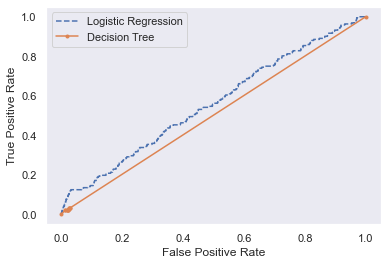

In [88]:
lr_fpr, lr_tpr, _ = roc_curve(y_no_test, y_scores_lr)
dt_fpr, dt_tpr, _ = roc_curve(y_no_test, y_scores_dt)
# plot the roc curve for the model
plt.plot(lr_fpr, lr_tpr, linestyle='--', label='Logistic Regression')
plt.plot(dt_fpr, dt_tpr, marker='.', label='Decision Tree')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

### Based on the model validation scores, It is recommended to use Decision Tree model because it is an imbalanced dataset and Accuracy and F1 score is higher than the Logistic Regression Model.

## _k_-fold Cross-validation

#### Logistic Regression _k_-fold Cross-validation

In [90]:
# let's use three folds
k_folds = 3
clf = LogisticRegression(solver='liblinear', class_weight='balanced', random_state=1111)
auc_scores = []

for k in range(k_folds):
    
    X_train_k, X_test_k, y_train_k, y_test_k = \
        train_test_split(X_NO, y_no, test_size=1/k_folds)

    clf.fit(X_train_k, y_train_k)
    
    y_scores_k = clf.predict_proba(X_test_k)[:, 1]

    # calcualte AUC
    auc = roc_auc_score(y_test_k, y_scores_k)
    
    auc_scores.append(auc)
    
print('AUC Scores: ', auc_scores)
print('Mean AUC Score: ', sum(auc_scores)/len(auc_scores))

AUC Scores:  [0.5283183289809258, 0.5596486877084162, 0.535150906598953]
Mean AUC Score:  0.541039307762765


#### Decision Tree _k_-fold Cross-validation

In [91]:
# let's use three folds
k_folds = 3
D_clf = DecisionTreeClassifier(class_weight='balanced', random_state=1111)
auc_scores = []

for k in range(k_folds):
    
    X_train_k, X_test_k, y_train_k, y_test_k = \
        train_test_split(X_NO, y_no, test_size=1/k_folds)

    clf.fit(X_train_k, y_train_k)
    
    y_scores_k = clf.predict_proba(X_test_k)[:, 1]

    # calcualte AUC
    auc = roc_auc_score(y_test_k, y_scores_k)
    
    auc_scores.append(auc)
    
print('AUC Scores: ', auc_scores)
print('Mean AUC Score: ', sum(auc_scores)/len(auc_scores))

AUC Scores:  [0.5298278530455823, 0.5363000899611778, 0.5194034856870106]
Mean AUC Score:  0.5285104762312569
